# Импорт

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import distance_metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, RocCurveDisplay, auc

from joblib import dump


# Загружаем датасет и разбиваем её на выборку.

In [14]:
data = pd.read_csv('../../Data/DataLaba2/neo_task_smoted.csv')
X_train, X_test, y_train, y_test = train_test_split(data.drop('hazardous', axis=1), data['hazardous'], test_size=0.85, random_state=42)
X_train.shape, y_train.shape


((24598, 4), (24598,))

In [15]:
data

,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,-0.999187,-0.528599,-0.972789,0.407593,0.0
1,-0.998421,-0.935292,-0.126239,0.290780,0.0
2,-0.997101,-0.534989,0.748307,0.182311,0.0
3,-0.999016,-0.650926,-0.663033,0.374218,0.0
4,-0.992669,-0.430407,0.906601,0.015436,0.0
...,...,...,...,...,...
163987,-0.994367,-0.604209,-0.841236,0.062991,1.0
163988,-0.993778,-0.757087,-0.160396,0.045115,1.0
163989,-0.989685,-0.114495,-0.067884,-0.046048,1.0
163990,-0.986634,-0.067341,0.716200,-0.093033,1.0


# Подбираем гиппер-параметры.

In [16]:
gradient_boosting_classifier_optimal_params = RandomizedSearchCV(GradientBoostingClassifier(),
                                                                 {
                                                                    'loss': ['log_loss', 'exponential'],
                                                                    'n_estimators': np.arange(50, 150),
                                                                    'criterion': ['friedman_mse', 'squared_error'],
                                                                    'min_samples_split': np.arange(2, 10),
                                                                    'min_samples_leaf': np.arange(1, 9),
                                                                    'min_weight_fraction_leaf': np.arange(0, 0.5, 0.01),
                                                                    'max_depth': np.arange(4, 15)
                                                                 },
                                                                 n_iter=4,
                                                                 n_jobs=4,
                                                                 scoring='f1',
                                                                 random_state=71
                                                                 ).fit(X_train, y_train)
gradient_boosting_classifier_optimal_params.best_params_

{'n_estimators': 105,
 'min_weight_fraction_leaf': 0.04,
 'min_samples_split': 8,
 'min_samples_leaf': 6,
 'max_depth': 11,
 'loss': 'exponential',
 'criterion': 'squared_error'}

# Обучение

In [17]:
gradient_boosting_classifier = GradientBoostingClassifier(loss=gradient_boosting_classifier_optimal_params.best_params_['loss'] if 'loss' in gradient_boosting_classifier_optimal_params.best_params_ else 'log_loss',
                                                          n_estimators=gradient_boosting_classifier_optimal_params.best_params_['n_estimators'] if 'n_estimators' in gradient_boosting_classifier_optimal_params.best_params_ else 100,
                                                          criterion=gradient_boosting_classifier_optimal_params.best_params_['criterion'] if 'criterion' in gradient_boosting_classifier_optimal_params.best_params_ else 'friedman_mse',
                                                          min_weight_fraction_leaf=gradient_boosting_classifier_optimal_params.best_params_['min_weight_fraction_leaf'] if 'min_weight_fraction_leaf' in gradient_boosting_classifier_optimal_params.best_params_ else 0,
                                                          min_samples_split=gradient_boosting_classifier_optimal_params.best_params_['min_samples_split'] if 'min_samples_split' in gradient_boosting_classifier_optimal_params.best_params_ else 2,
                                                          min_samples_leaf=gradient_boosting_classifier_optimal_params.best_params_['min_samples_leaf'] if 'min_samples_leaf' in gradient_boosting_classifier_optimal_params.best_params_ else 1,
                                                          max_depth=gradient_boosting_classifier_optimal_params.best_params_['max_depth'] if 'max_depth' in gradient_boosting_classifier_optimal_params.best_params_ else 3,
                                                          )
gradient_boosting_classifier.fit(X_train, y_train)

GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                           max_depth=11, min_samples_leaf=6,
                           min_samples_split=8, min_weight_fraction_leaf=0.04,
                           n_estimators=105)

# Предсказание

In [18]:
y_predict = gradient_boosting_classifier.predict(X_test)
y_predict

array([1., 0., 1., ..., 0., 1., 0.])

# Оценка

In [19]:
print('Accuracy')
print(accuracy_score(y_test, y_predict))

Accuracy
0.8799230956856106


In [20]:
print('Confusion matrix')
print(confusion_matrix(y_test, y_predict))

Confusion matrix
[[53659 16075]
 [  663 68997]]


In [21]:
print('Precision, Recall, F\n', classification_report(y_test, y_predict))

Precision, Recall, F
               precision    recall  f1-score   support

         0.0       0.99      0.77      0.87     69734
         1.0       0.81      0.99      0.89     69660

    accuracy                           0.88    139394
   macro avg       0.90      0.88      0.88    139394
weighted avg       0.90      0.88      0.88    139394



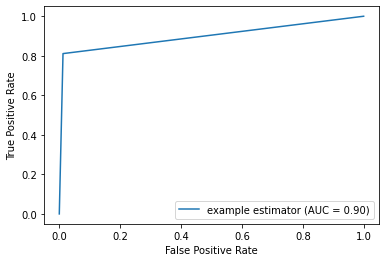

In [22]:
fpr, tpr, thresholds = roc_curve(y_predict, y_test)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()